### Conditional probabilities and Bayesian statistics


People rely on the collective intelligence of previous experiences to protect themselves or do better in future. Save themselves from eating bad food at the wrong restaurant or avoid stunning flops at the theater etc. 

In this notebook we will consider how to implement a Bayesian estimation of the mean of movie reviews with a limited number of observations. Some of the work is referenced from Benjamin bengfort's [computing-a-bayesian-estimate-of-star-rating-means](https://districtdatalabs.silvrback.com/computing-a-bayesian-estimate-of-star-rating-means)

we will be working with the MovieLens data set. The dataset contains 100,000 ratings from 1,000 users on nearly 1,700 movies. 

#### Loading the dataset

Load the data "u.data" and "u.item" from the directory "/datasets/movie_lens/ml-100k/". First thing we need to do is merge datasets u.data and u.test into one single dataframe.

In [1]:
# Dataset doesn't have names for variables. 
reviews_data= read.csv("../../../datasets/movie_lens/ml-100k/u.data",header=FALSE,sep='\t',col.names=c("user_id",
                                                    "movie_id","rating","timestamp"))

# we are not interetsed in the last column in the dataset 'timestamp'. So exclude the 4 th column from the dataframe by 
#excluding it from the list.
reviews_data = reviews_data[,c(1,2,3)]
head(reviews_data)

,user_id,movie_id,rating
1,196,242,3
2,186,302,3
3,22,377,1
4,244,51,2
5,166,346,1
6,298,474,4


In [2]:
# The columns in the dataset are separated from each other by '|' operator. So we specify the separator as '|'
movie_names= read.csv("../../../datasets/movie_lens/ml-100k/u.item",header=FALSE,sep='|')
head(movie_names)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24
1,1,Toy Story (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,GoldenEye (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,Four Rooms (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4,Get Shorty (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5,Copycat (1995),01-Jan-1995,NA,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,6,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),01-Jan-1995,NA,http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 'u.item' has has bunch of columns which we are not interested or irrelevant to the question we are trying to answer. So we 
#exclude them from the dataset by specifying to include only first two columns "movie_id", "title" in the dataframe.
movie_names=movie_names[,c(1,2)]
names(movie_names)=c("movie_id", "title")
head(movie_names)

,movie_id,title
1,1,Toy Story (1995)
2,2,GoldenEye (1995)
3,3,Four Rooms (1995)
4,4,Get Shorty (1995)
5,5,Copycat (1995)
6,6,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)


In [12]:
# We need to merge reviews_data and movie_names. The dataframe 'reviews_data' doesn't has movie names which are available 
# in movie_names dataframe. When we merge two dataframes they should be equal in number of rows and a common variable should 
# exist between two dataframes with same values to make the data merge possible.

# Movie_id's is a common column in reviews_data and movie_names. 
ratings_data <- merge(reviews_data,movie_names,by="movie_id")
head(ratings_data)

,movie_id,user_id,rating,title
1,1,650,3,Toy Story (1995)
2,1,635,4,Toy Story (1995)
3,1,1,5,Toy Story (1995)
4,1,514,5,Toy Story (1995)
5,1,250,4,Toy Story (1995)
6,1,210,5,Toy Story (1995)


**Reference: **[merge()](http://www.statmethods.net/management/merging.html)

In [16]:
# Each movie has bunch of reviews. When we compare two movies, we go with the movie rating. But the number of reviews is equally 
# important to consider. A movie with an average rating of 4.5 with 100 reviews should be a lot better than a movie with a 
# rating of 5 based on just 1 review with a rating of 5 . We need to find out average rating for each movie and total number of 
# reviews each has got. 

# Below we are trying to find the average of movie_rating and sum the number of reviews each movie has got.
                    #aggregate ratings for each movie_name    #aggregate based on movie_id    #Apply mean on aggregated movie_data
rating_means=merge(aggregate(ratings_data[c("rating")],by=list(movie_id=ratings_data$movie_id), mean),
                   #aggregate ratings for each movie_name    #aggregate based on movie_id    #Find the length of aggregated data
                   aggregate(ratings_data[c("rating")],by=list(movie_id=ratings_data$movie_id), length),by="movie_id")
rating_means=merge(rating_means,movie_names,by="movie_id")

# Assign proper names to the new columns we just created
names(rating_means) = c("movie_id","avg_rating","no_of_reviews","title")

In [17]:
# Display the first few rows of rating_means dataset in the descending rorder of average rating and and ascending order of 
#number of reviews. 
head(rating_means[with(rating_means, order(-avg_rating,no_of_reviews)), ])

,movie_id,avg_rating,no_of_reviews,title
814,814,5,1,"Great Day in Harlem, A (1994)"
1122,1122,5,1,They Made Me a Criminal (1939)
1201,1201,5,1,Marlene Dietrich: Shadow and Light (1996)
1536,1536,5,1,Aiqing wansui (1994)
1599,1599,5,1,Someone Else's America (1995)
1653,1653,5,1,Entertaining Angels: The Dorothy Day Story (1996)


In [18]:
# Display the rows of rating_means dataset in the descending rorder of number of reviws and and ascending order of 
# average rating
head(rating_means[with(rating_means, order(-no_of_reviews,avg_rating)), ])

,movie_id,avg_rating,no_of_reviews,title
50,50,4.35849056603774,583,Star Wars (1977)
258,258,3.80353634577603,509,Contact (1997)
100,100,4.15551181102362,508,Fargo (1996)
181,181,4.00788954635108,507,Return of the Jedi (1983)
294,294,3.15670103092783,485,Liar Liar (1997)
286,286,3.65696465696466,481,"English Patient, The (1996)"


When we sort the dataset based on descending order of avg_rating we get the top movies as (Aiqing Wansui (1994), Great Day in Harlem, A (1994), They Made Me a Criminal (1939), and more) all have a mean rating of 5 stars but also significantly less than 10 reviewers each. These are not the most popular movies for sure.

On other hand we sorted the dataset based on number of reviews, which gave us a different list of movies. Even this list doesn't represent the true list of top movies.

In [19]:
nrow(rating_means)
dim(rating_means[rating_means$no_of_reviews<=10, ])

[1] 1682

[1] 563   4

Lets plot average rating of movies against the number of reviews for the ratingmeans data set.

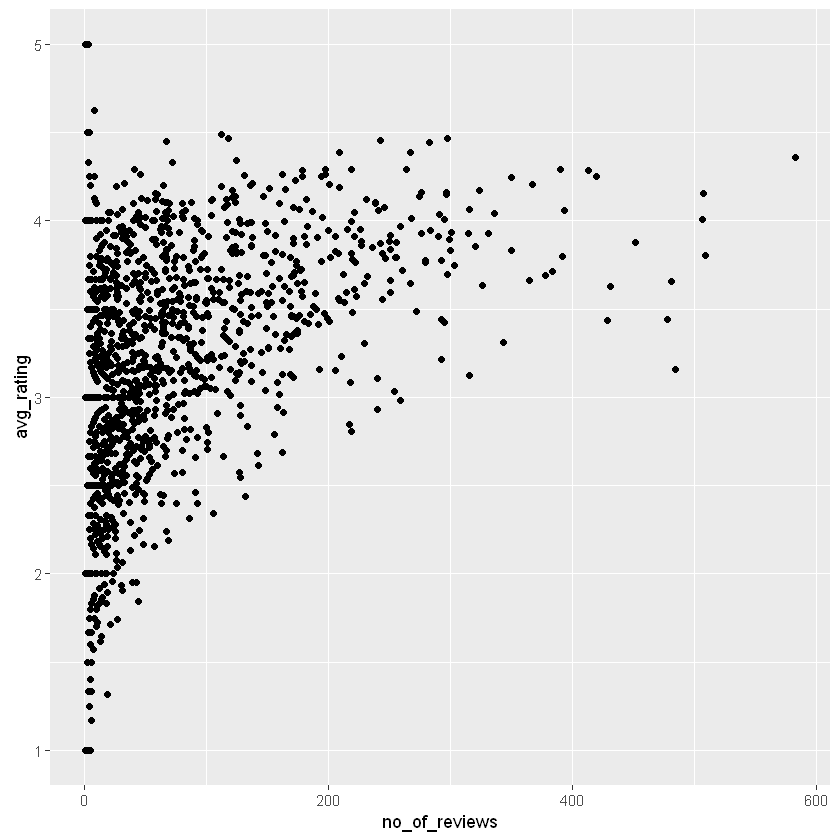

In [23]:
library(ggplot2)
ggplot(rating_means,aes(x=no_of_reviews,y=avg_rating))+geom_point()

The plot suggests there are many movies have 0 to 100 reviews and out of them there are mant exist with 10 or less reviews. We can't say that a movie is good if the number of reviews are more as there are many movies with a rating of above 4 with very few reviews. Lets plot a hexbix plot that captures bunch of similar observations in a bin. 

Loading required package: hexbin


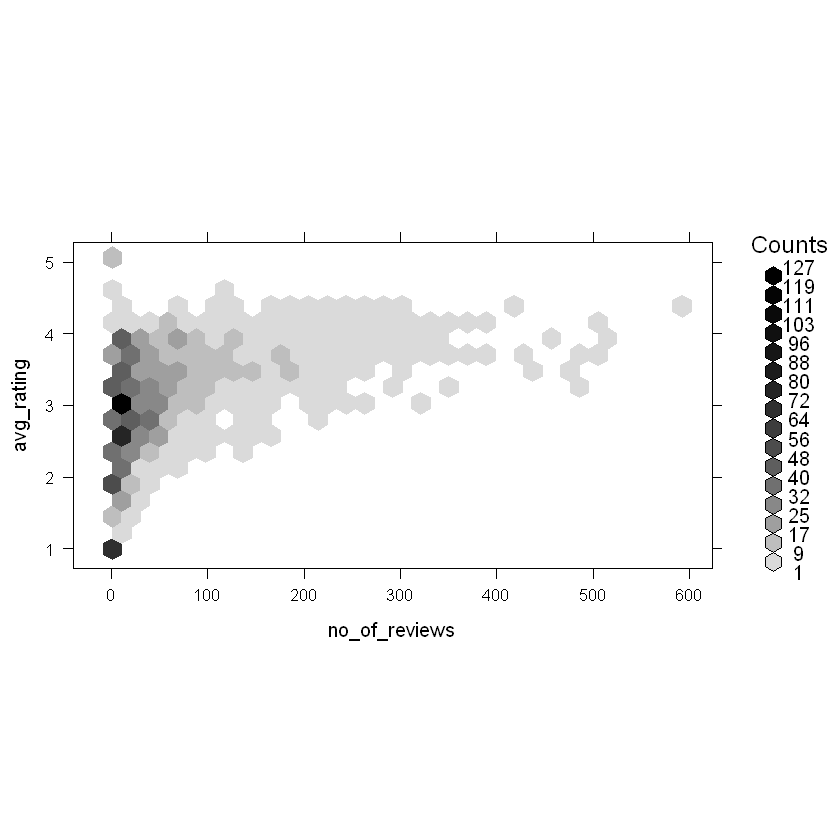

In [21]:
# install.packages("hexbin",repo="http://cran.uk.r-project.org")
require(hexbin)
my.colors <- function (n) {
  rev(LinGray(n, beg=1, end=92))
}

hexbinplot(avg_rating ~ no_of_reviews, data=rating_means,colramp = my.colors)

**Reference: ** [hexbin()](https://cran.r-project.org/web/packages/hexbin/hexbin.pdf)

In [28]:
print("Distribution table with no of reviews <= 10 and average rating <= 3")
table(rating_means$no_of_reviews<=10,rating_means$avg_rating<=3)

print("Distribution table with no of reviews <= 10 and average rating <= 4")
table(rating_means$no_of_reviews<=10,rating_means$avg_rating<=4)

[1] "Distribution table with no of reviews <= 10 and average rating <= 3"


       
        FALSE TRUE
  FALSE   784  335
  TRUE    167  396

[1] "Distribution table with no of reviews <= 10 and average rating <= 4"


       
        FALSE TRUE
  FALSE   107 1012
  TRUE     25  538

In [32]:
print("Average rating of movies with no of reviws <=10")
t(tapply(rating_means$avg_rating,rating_means$no_of_reviews>=0 & rating_means$no_of_reviews<=10,mean))

print("Average rating of movies with no of reviws > 10")
t(tapply(rating_means$avg_rating,rating_means$no_of_reviews>10,mean))

print("Average rating of movies with no of reviws >10 and <=100")
t(tapply(rating_means$avg_rating,rating_means$no_of_reviews>=10 & rating_means$no_of_reviews<=100,mean))

[1] "Average rating of movies with no of reviws <=10"


FALSE,TRUE
3.292109,2.646601


[1] "Average rating of movies with no of reviws > 10"


FALSE,TRUE
2.646601,3.292109


[1] "Average rating of movies with no of reviws >10 and <=100"


FALSE,TRUE
3.021668,3.133479


This figure shows that the average rating of a movie is actually slightly higher than 3. Most number of movies have reviewrs less than 100 while decent amount of movies have 100 to 300 reviews. 

The hexbin plot gets our attention when there are less than 10 reviewers. The tails on the graph are dramatic. Movies with low number of reviews have equal number of good and bad rating movies. On the other hand movies with higher reviews tend to be better rating movies. If there are less than 10 reviews, movies have an average rating of 2.64, whereas after 10 reviews movies have an average rating of 3.29.

We can hypothesize two things from above observations. First, we become confident that a mean rating is good so long as it has between 10 and 100 reviews. Secondly, we know that the average rating is between 3.0 and 3.5 when a movie has that many number of reviews. Using these two hypotheses, we can come up with a rule that will allow us to rank movies according to both the mean rating the movie has received as well as the number of reviews the movie got. We can formalize these hypotheses with Bayesian estimation.

### Bayesian estimation

Using bayesian estimation we will try to code our hypotheses.

In order to estimate probabilities you have to generate observations. Let's look at a simple example. 

Suppose we want to estimate the likelihood that someone will give a movie a thumbs up. We would initially assign each person a probability $X$ and initialize it to 0.5 probability that they will give the movie a thumbs up. We would then go stand outside a theater where that movie was playing and ask people leaving the theater that saw that movie whether they would give the movie a thumbs up or a thumbs down. The result would be a collection of observations that we would use to update our $X$, making it more accurate. The updated $X$ based on $O$, the sequence of observations after $N$ tests, is called the **posterior distribution.**

Bayes formula tells us how to compute the probability of $X$ given $O$:

<img src="../images/computing-bayesian-average-of-star-ratings-2_large.PNG">

P(O) is the probability of observation and our prior, P(X), is what we believe the distribution of the probabilities X is before seeing any data. When you don't know anything about the probabilities, you can start with the assumption that there is an underlying uniform distribution where all possible values of the random variable X are equally likely. Therefore, we are only interested in the proportionality relationship between P(X|O) (read "the probability of X given O") and P(O|X) (read "the probability of O given X"). The probability of O given X (P(O|X)) is called the likelihood and can be computed by taking the product of the probability of each observation (assuming they are independent):

What is the expected value of the average rating given a posterior in the shape of our Dirichlet distribution?

P()

### Bayesian average calculation

Select some m that represents a prior for the average rating.

Select a C that represents our confidence in the prior.

According to our hypothesis: m is the average rating we can expect for movie, given some minimum number of observations, C. We could estimate m to be 3.25 and C to be 50 according to our observations above. 

The Bayesian average would then be:

<img src="../images/bayesian formula.PNG">

Replacing N for the number of reviews and C and m for our confidence and prior respectively. Let's update our rating_means dataframe to reflect these new insights:

In [35]:
len <- nrow(rating_means)
for(i in 1:len)
    {
#     print(rating_means$no_of_reviews[i])
        rating_means$bayes[i] = ((50*3.1) + rating_means$no_of_reviews[i])/(50 + rating_means$no_of_reviews[i])
}

rating_means[with(rating_means, order(-bayes,-avg_rating,-no_of_reviews)), ]
max(rating_means$bayes)

,movie_id,avg_rating,no_of_reviews,title,bayes
814,814,5,1,"Great Day in Harlem, A (1994)",3.05882352941176
1122,1122,5,1,They Made Me a Criminal (1939),3.05882352941176
1201,1201,5,1,Marlene Dietrich: Shadow and Light (1996),3.05882352941176
1536,1536,5,1,Aiqing wansui (1994),3.05882352941176
1599,1599,5,1,Someone Else's America (1995),3.05882352941176
1653,1653,5,1,Entertaining Angels: The Dorothy Day Story (1996),3.05882352941176
711,711,4,1,"Substance of Fire, The (1996)",3.05882352941176
1130,1130,4,1,Jupiter's Wife (1994),3.05882352941176
1235,1235,4,1,"Big Bang Theory, The (1994)",3.05882352941176
1452,1452,4,1,Lady of Burlesque (1943),3.05882352941176


[1] 3.058824